# Disease Course Sequencing with the EBM
## Event-Based Model of disease progression
Author: Neil Oxtoby, UCL

## Objectives:

This notebook walks you through how to fit an event-based model of disease progression using publicly available software and simulated data.

The steps involved:
- Load input data
  - e.g., a CSV table of disease features (biomarkers) in a cohort including patients and healthy controls
- Prepare the input data: select a subset of features; perform some basic statistical checks; etc.
- Fit the model
- Perform cross-validation

We add additional steps as didactic exemplars of good practice in data-driven disease progression modelling. 

## The set-up

This notebook is currently designed to run in a specially prepared conda environment, using the [KDE EBM](https://github.com/ucl-pond/kde_ebm) package (see [installation instructions](https://github.com/ucl-pond/kde_ebm/blob/master/INSTALL.md) on GitHub).

In the future we may support running this in the cloud.

In [1]:
# Import some packages
import numpy as np
import matplotlib.pyplot as plt

## Simulate some data

Text(0, 0.5, 'sigmoid(t)')

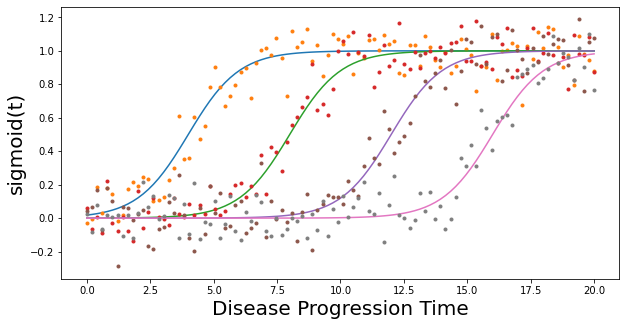

In [4]:
N = 4   # number of events/features
J = 100 # number of patients

noise_scale = 0.1

dp = np.linspace(0, 20, J)
def sigmoid(t,a=1,b=-10):
    return 1/(1 + np.exp(-a*(t-b)))

gradients = np.array([1,1,1,1])
onsets    = np.array([4,8,12,16])

X = np.empty(shape=(J,N))
fig,ax = plt.subplots(figsize=(10,5))
for a,b,k in zip(gradients,onsets,range(len(gradients))):
    # print('a = %i, b = %i' % (a,b))
    x = sigmoid(t=dp,a=a,b=b)
    #print(x)
    ax.plot(dp, x)
    y = x + np.random.normal(0, noise_scale, x.size)
    X[:,k] = y
    ax.plot(dp, y,'.')

ax.set_xlabel("Disease Progression Time",fontsize=20) 
ax.set_ylabel("sigmoid(t)",fontsize=20)

In [5]:
#* Sample some controls
X_controls = np.empty(shape=X.shape)
for k in range(len(gradients)):
    X_controls[:,k] = np.random.normal(0, 0.05, (X_controls.shape[0],))

## Didactic step: Look at the data

1. Visual: look at the histograms of patients and controls
2. Statistical tests: use null hypothesis statistical tests of "differences" to select features
  - Loosely speaking, a significant difference suggests presence of "disease signal" (patient measurements are "different" to controls measurements) in a biomarker

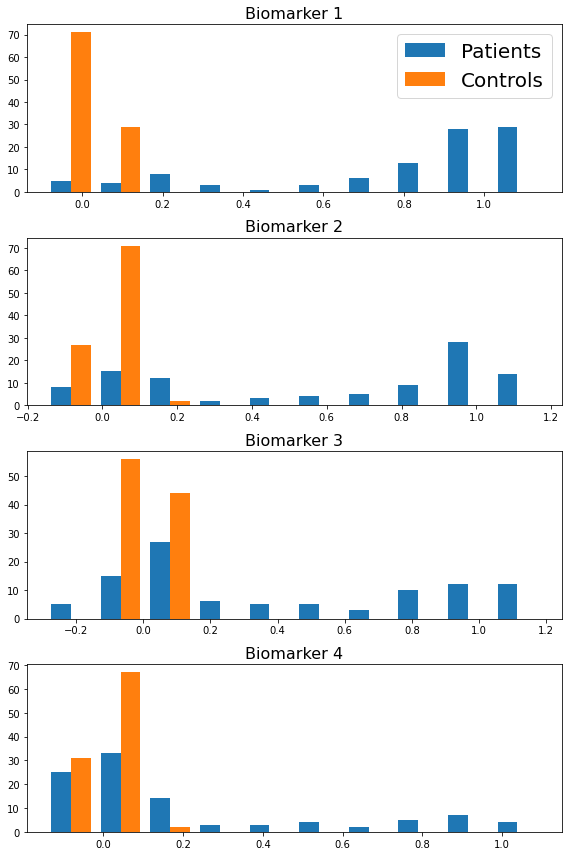

In [10]:
#* 1. Histograms
fig,ax = plt.subplots(N,1,figsize=(8,12))
for k in range(N):
    ax[k].hist([ X[:,k],X_controls[:,k]],label=['Patients','Controls'])
    ax[k].set_title('Biomarker %i' % (k+1),fontsize=16)
ax[0].legend(fontsize=20)
fig.tight_layout()

In [11]:
# 2. Basic statistical tests
# I use a nonparametric test because it works regardless of the data distributions 
# (some tests assume some level of Gaussianity)
from scipy import stats
print('FIXME')

FIXME


## Prepare data for fitting

Data matrix `X` has `M` individuals (patients, controls, prodromal/at-risk individuals) and `N` biomarkers/events

In [12]:
#* Setup data for fitting
y          = np.ones(shape=(X.shape[0],1))
y_controls = np.zeros(shape=(X_controls.shape[0],1))

X_patients_controls = np.concatenate((X,X_controls),axis=0)
y_patients_controls = np.concatenate((y,y_controls),axis=0)

X = X_patients_controls
y = y_patients_controls.flatten().astype(int)

## Fit mixture models

This step maps biomarker values `x` (columns of data matrix `X`) to `p(event)`, allowing for patients to be at different stages of cumulative abnormality.

Typical group-level analyses simply compare measurements from patients with controls, e.g., looking for statistical "differences" in the mean values. The mixture model allows for patients to have both abnormal observations that deviate from controls (these are early disease events), and normal observations (these will be later disease events)


In [19]:
from kde_ebm.mixture_model import fit_all_kde_models, fit_all_gmm_models, get_prob_mat

from kde_ebm.plotting import mixture_model_grid, mcmc_uncert_mat, mcmc_trace, stage_histogram

from kde_ebm.mcmc import mcmc, parallel_bootstrap, bootstrap_ebm, bootstrap_ebm_fixedMM, bootstrap_ebm_return_mixtures


In [14]:
#* Label the biomarkers/events
e = ['Early','Early-ish','Late-ish','Late']
e_labels = e
#* Direction of progression (1 = biomarker increases in patients; -1 = biomarker decreases in patients)
#  This is a feature of the KDE EBM software.
e_disease_direction_dict = {'Early':1,'Early-ish':1,'Late-ish':1,'Late':1}
e_disease_direction = [e_disease_direction_dict[f] for f in e]

In [17]:
kde_mixtures = fit_all_kde_models(
    X, y,
    implement_fixed_controls = True,
    patholog_dirn_array      = e_disease_direction
)

(<Figure size 720x720 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Early'}>,
         <AxesSubplot:title={'center':'Early-ish'}>],
        [<AxesSubplot:title={'center':'Late-ish'}>,
         <AxesSubplot:title={'center':'Late'}>]], dtype=object))

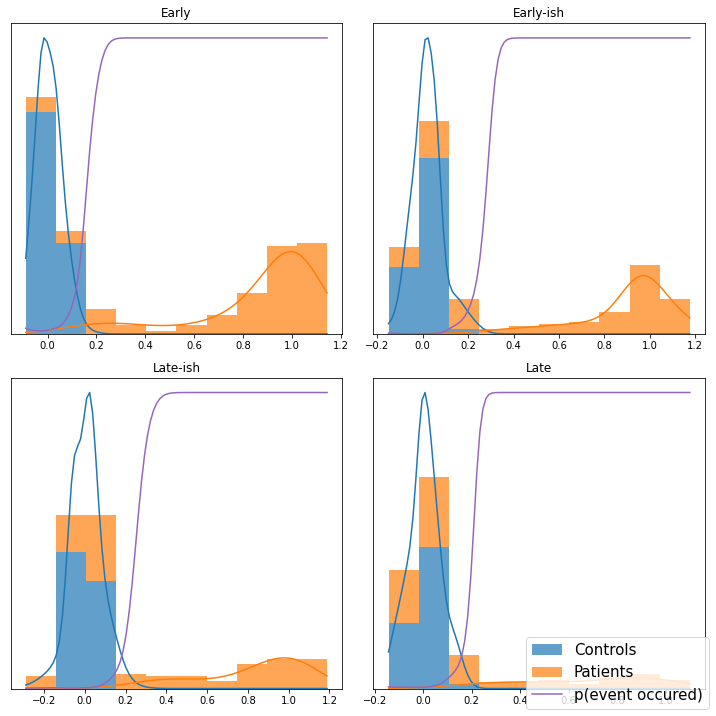

In [20]:
#* View the mixture models
mixture_model_grid(
    X,y,
    kde_mixtures,
    score_names=e,
    class_names=['Controls','Patients']
)

## Sequencing using MCMC: Markov Chain Monte Carlo

This is a standard method for approximating a model posterior when exact inference is intractable.

Here we are performing maximum likelihood inference. The EBM posterior is intractable in general because evaluating the likelihood function requires calculating the likelihood of all `N!` possible sequences for `N` biomarkers.

This quickly explodes for `N > 6`, so we generate _random samples from the posterior_ (the full set of possible sequences) using MCMC, and keep only those sequences that increase the likelihood (ideally towards the maximum).

In general, the posterior won't be a convex function, i.e., one having a single easy-to-find maximum.

In practice, the posterior could consist of multiple maxima at different locations in parameter space. To avoid getting "stuck" in a local maximum, we follow good machine learning practice when searching parameter space to sample from the posterior: multiple random initialisations of the sampling, greedy initialisation, and MCMC sampling.

Details of the bespoke MCMC algorithm used here are in the original EBM paper: [Fonteijn _et al._, NeuroImage (2012)](https://doi.org/10.1016/j.neuroimage.2012.01.062).



/Users/noxtoby/Documents/code/github/kde_ebm/kde_ebm/mcmc/mcmc.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ML order   : Early, Early-ish, Late-ish, Late


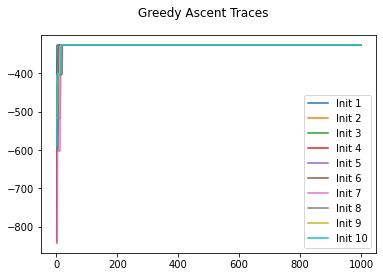

In [21]:
#* MCMC sequencing
mcmc_samples = kde_ebm.mcmc.mcmc(X, kde_mixtures)
#* Maximum Likelihood sequence over all samples
seq_ml = mcmc_samples[0].ordering
# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([e_labels[k] for k in seq_ml]))
      

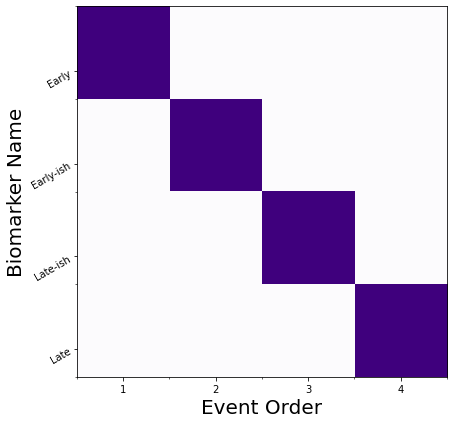

In [27]:
# View the ML posterior
f,a = mcmc_uncert_mat(mcmc_samples, ml_order=None, score_names=e_labels)

### A prettier solution

I define some convenience functions, then use them to plot

In [34]:
import itertools
def extract_pvd(ml_order,samples):
    if type(ml_order) is list:
        #* List of PVDs from cross-validation/bootstrapping
        n_ = len(ml_order[0])
        pvd = np.zeros((n_,n_))
        #all_orders = np.array(ml_order)
        if type(samples[0]) is list:
            #* 10-fold CV returns MCMC samples for each fold separately in a list - concatenate them here
            all_samples = list(itertools.chain.from_iterable(samples))
        else:
            #* Bootstrapping returns MCMC samples pre-concatenated
            all_samples = samples
        all_orders = np.array([x.ordering for x in all_samples])
        for i in range(n_):
            pvd[i, :] = np.sum(all_orders == ml_order[0][i], axis=0)
        #pvd_cv, cv_rank = reorder_PVD_average_ranking(PVD=pvd)
        pvd, rank = reorder_PVD(pvd)
        seq = [ml_order[0][i] for i in rank]
    else:
        #* Single PVD (ML results)
        n_ = len(ml_order)
        pvd = np.zeros((n_,n_))
        samples_ = np.array([x.ordering for x in samples])
        seq = ml_order
        for i in range(n_):
            pvd[i, :] = np.sum(samples_ == seq[i], axis=0)
    return pvd, seq

def reorder_PVD(PVD,mean_bool=False,edf_threshold=0.5):
    """
    Reorders a PVD by scoring the frequencies in each row, then ranking in increasing order.

    Score: integral of complementary empirical distribution (1-EDF) up to a threshold.
    Rationale: the sooner the EDF gets to the threshold, the earlier it should be in the ranking.

    """

    if mean_bool:
        n_ = PVD.shape[0]
        ranking = np.linspace(1,n_,n_) # weights
        weights = PVD
        mean_rank = []
        for i in range(n_):
            mean_rank.append( sum( weights[i,:] * ranking ) / sum(weights[i,:]) )
        new_order = np.argsort(mean_rank)
    else:
        #* Find where the empirical distribution first exceeds the threshold
        edf = np.cumsum(PVD,axis=1)
        edf = edf / np.tile(np.max(edf,axis=1).reshape(-1,1),(1,edf.shape[1]))
        edf_above_threshold = []
        for k in range(edf.shape[0]):
            edf_above_threshold.append(np.where(edf[k,:]>=edf_threshold)[0][0])
        #* Ties implicitly split by original ordering in the PVD (likely the ML ordering)
        edf_rank = np.argsort(edf_above_threshold)
        new_order = edf_rank

    PVD_new = PVD[new_order,:]
    # PVD_new = np.zeros((n_,n_))
    # for i in range(n_):
    #     PVD_new[i, :] = PVD[new_order[i],:]

    return PVD_new, new_order

# Frontiers default is pdf with 300dpi
# And run it all through imagemagick after to convert
def save_plot(fig, fname, fig_format="png", dpi=150, **kwargs):
    fig.savefig(
        f"{fname}.{fig_format}",
        dpi=300,
        bbox_inches="tight",
        **kwargs
    )

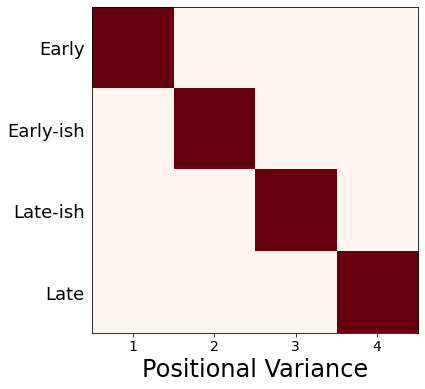

In [35]:
# Get labels
nom = 'tute'
#* Plot EBM (PVD)
pvd_ml, seq_ml = extract_pvd(ml_order=seq_ml,samples=mcmc_samples)
reorder_ml = np.argsort(seq_ml)
pvd_ml_ = pvd_ml[:][reorder_ml]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = e_labels
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_ml]
ax.imshow(pvd_ml_[:][seq_ml], interpolation='nearest', cmap='Reds')

n_biomarkers = pvd_ml.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0.0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Positional Variance', fontsize=24)
ax.grid(False)

save_plot(fig, nom+"-PVD_ML")

## Cross-validation

**FIXME: add this**


## Patient staging utility

**FIXME: add this**

Can compare data from each individual (patients/controls/at-risk) with the model and calculate a `p(event)` vector